In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# %matplotlib widget

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import statsmodels.graphics.tsaplots as sgt
import scipy.stats as stats

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline
sns.set_context("talk")

# random state
RS = 1
# %matplotlib widget

In [137]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

In [138]:
# #В колабе импортируем все необходимые библиотеки
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# #Привязываем гуглдиск к колабу
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "19nKbfpora5U62vor4G5sWISLedbZwntX"})
# # https://drive.google.com/file/d/19nKbfpora5U62vor4G5sWISLedbZwntX/view?usp=drive_link
# download.GetContentFile("2024-03-04_08-17-49.emg8")

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "1vqfALT-qDf9EDKohTZVwNL-Izl_0CAeO"})
# # https://drive.google.com/file/d/1vqfALT-qDf9EDKohTZVwNL-Izl_0CAeO/view?usp=drive_link
# download.GetContentFile("2024-03-04_08-17-49.emg8.protocol")

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "1jG2kqCtuzo0PCztq0wYj3xtVxV68TB0s"})
# # https://drive.google.com/file/d/1jG2kqCtuzo0PCztq0wYj3xtVxV68TB0s/view?usp=drive_link
# download.GetContentFile("2024-03-04_10-00-21.emg8")

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "1V75f0C0az94HFErjX9dIfMlI0PN40Mu3"})
# # https://drive.google.com/file/d/1V75f0C0az94HFErjX9dIfMlI0PN40Mu3/view?usp=drive_link
# download.GetContentFile("2024-03-04_10-00-21.emg8.protocol")

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "1cGM7grbl2n5XWL2nSPrrPmdYCLPEutwW"})
# # https://drive.google.com/file/d/1cGM7grbl2n5XWL2nSPrrPmdYCLPEutwW/view?usp=drive_link
# download.GetContentFile("2024-03-04_11-11-02.emg8")

# # Загружаем файл в колаб
# download = drive.CreateFile({"id": "1XPC8iy-MC9nJZCcaW2kBONTyOO5souwD"})
# # https://drive.google.com/file/d/1XPC8iy-MC9nJZCcaW2kBONTyOO5souwD/view?usp=drive_link
# download.GetContentFile("2024-03-04_11-11-02.emg8.protocol")


# IO utils


# Data

In [139]:
# palm_file = './temp/2024-03-04_08-17-49.emg8'
palm_file = './temp/2024-03-15_16-40-43.emg8'
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='warn')
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
gestures.sort_index(inplace=True)
gestures = gestures.iloc[1:]
gestures.reset_index(drop=True, inplace=True)

print(gestures.shape)
gestures.head()

(10181, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,385736.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.05
1,385769.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
2,385802.0,33.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
3,385835.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.15
4,385868.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.18


In [140]:
gestures['id'].value_counts()

id
0    5333
2     971
6     970
7     970
8     969
1     968
Name: count, dtype: int64

In [141]:
OMG_CH = np.arange(50).astype(str)
gestures[OMG_CH] = gestures[OMG_CH].astype(float)

In [142]:
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

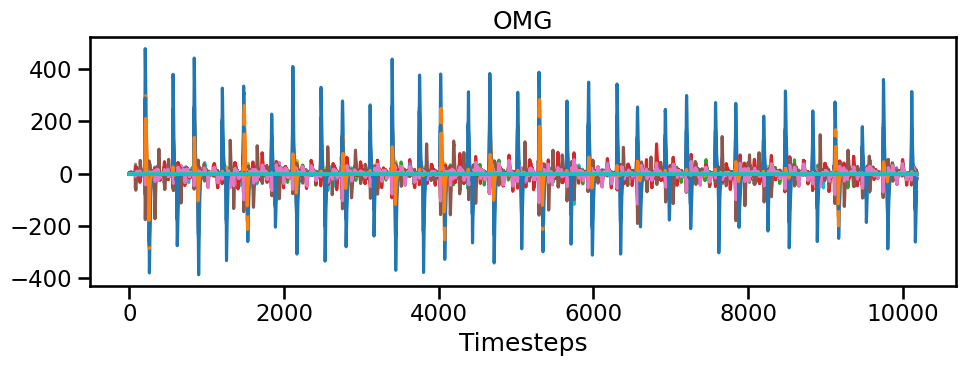

In [143]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [144]:
X = gestures[OMG_CH].values

le = LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(10181, 50) (10181,)


In [145]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

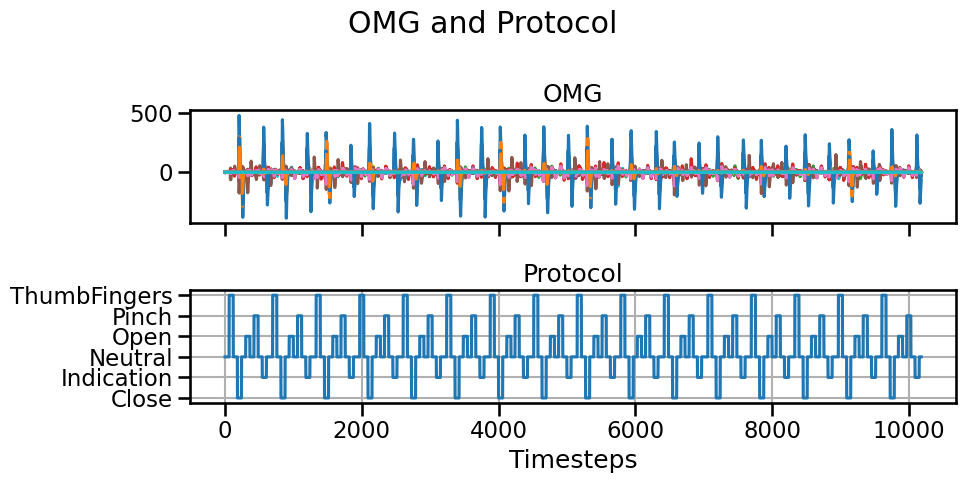

In [146]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

## Определение временной задержки целевой переменной.

### Визуализация имеющегося сдвига

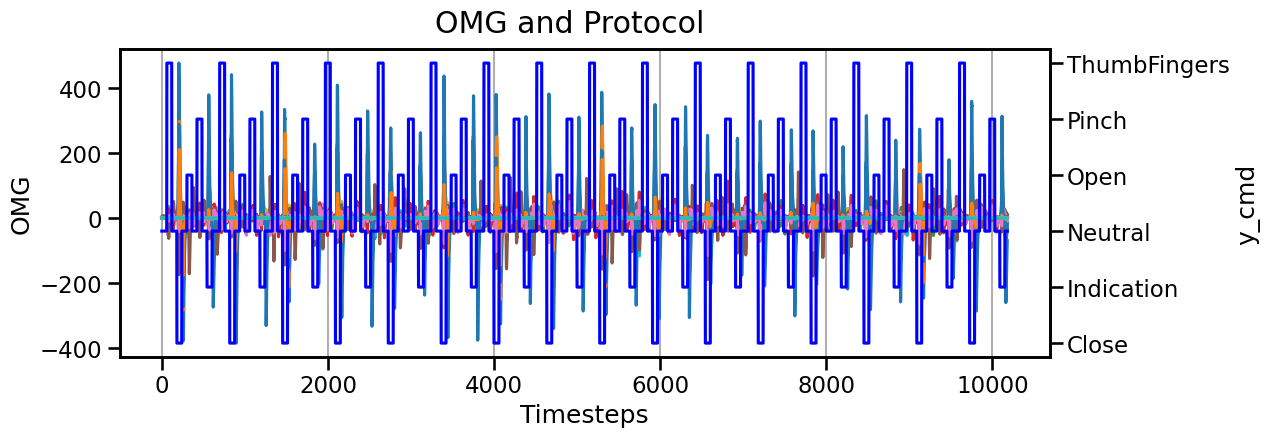

In [147]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df, 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [148]:
def add_feature_derivative(df):
  """Функция для добавления признака производной

    Args:
        df (DataFrame): датасет

    Returns:
        df_log(DataFrame): датасет с добавленным признаком производной
  """
  col_list_base = list(df.columns) #исходный список признаков
  df_temp = df.copy()
  for i in col_list_base:
    col_add = f'der_{i}' #название для нового признака
    df_temp[col_add] = df_temp[i].diff() #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем пустоты
  df_temp.drop(col_list_base, axis = 1 , inplace = True)
  return df_temp

def get_clean_lines(df, treshold = 1.5):
  """Функция для преобразования временного ряда.
  Преобразует все значения выше определенного порога в 1, ниже в 0

    Args:
        df (Series): датасет

    Returns:
        result(DataFrame): преобразованный датасет
  """
  result = np.zeros(df.shape) #создаем массив заполненный нулями размером с датасет
  means = np.mean(df) #выводим среднюю
  for i in range(df.shape[0]): #перебираем значения
    if abs(df[i]) > means*treshold:  #реализуем логику
      result[i] = 1
    else:
      result[i] = 0
  return pd.DataFrame(result)

def shift_definition(df, target):
  """Функция для нахождения временной задержки между командой и её исполнением

    Args:
        df (DataFrame): датасет с показаниями датчиков
        target (DataFrame): данные протокола выполнения команд
    Returns:
        best_shift (int): временной сдвиг
  """
  # рассчитываем производные значений временных датчиков
  gestures_der = add_feature_derivative(df)
  # суммируем модули значений производных
  gestures_der_sum = abs(gestures_der).sum(axis = 1)
  # обнуляем значения ниже порога
  gestures_der_sum_clean = get_clean_lines(gestures_der_sum, treshold = 1.5)

  # преобразуем целевую переменную в DataFrame
  target_df = pd.DataFrame(target)
  # рассчитываем производные значений таргета
  target_der = add_feature_derivative(target_df)
  # преобразуем таргет, если есть жест 1, если нет 0
  for i in range(len(target_der)):
      if (target_der.iloc[i] != 0).bool():
        target_der.iloc[i] = 1

  # объединяем преобразованный таргет и преобрразованную сумму производных в одну таблицу
  data = pd.concat([gestures_der_sum_clean.shift(1), target_der], axis=1).dropna()
  data.columns = ['y_t', 'first_derivative']
  # определяем, при каком сдвиге корреляция  максимальна
  corr_temp = []
  for i in range(1, 40):
    data['y_t'] = data['y_t'].shift(i)
    corr_coef = data.corr()
    corr_temp.append(corr_coef.iloc[1,0])
  l = pd.Series(corr_temp)
  best_shift = l[l == max(corr_temp)]
  return best_shift.index[0]

In [149]:
best_shift = shift_definition(gestures[OMG_CH], y_cmd)
print(best_shift)

/tmp/ipykernel_37550/3135940893.py:60: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if (target_der.iloc[i] != 0).bool():


30


### Визуализация соответствия команд и показаний от датчиков после сдвига целевой переменной

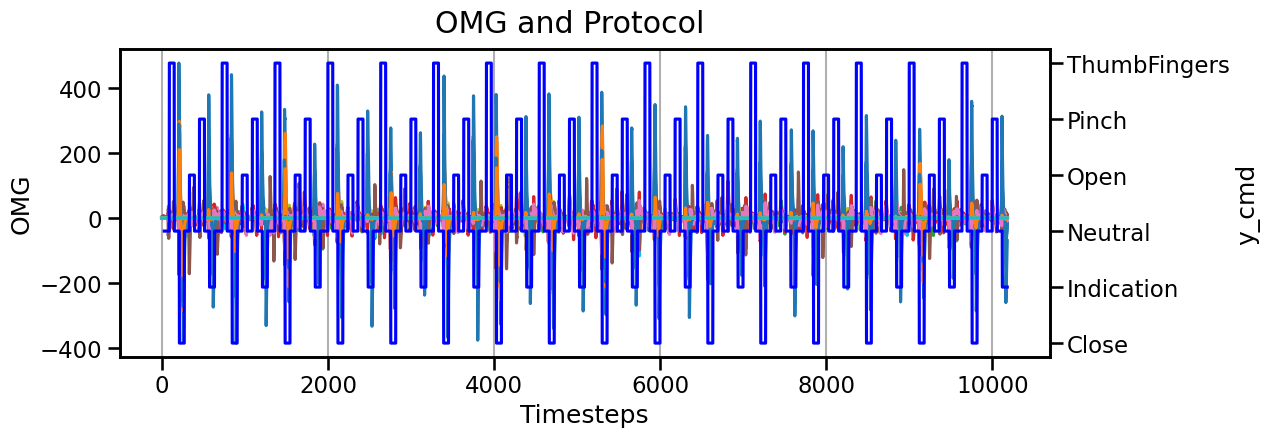

In [150]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df.shift(best_shift), 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [151]:
# сдвигаем значения таргета
target_df = target_df.shift(best_shift).fillna(0)
y_cmd_shift = target_df.to_numpy()
y_cmd_shift

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

## Определение максимального количества лагов

In [152]:
def plot_acf_pacf(series, lags, alpha=0.05):
    """Функция для построения графиков автокорреляции и частичной корреляции(коррелограм)

    Args:
        series (DataFrame, array): стационарный временной ряд
        lags (_type_): количество предыдущих наблюдений для поиска схожести/зависимости
        alpha (float, optional): Доверительный интервал. Defaults to 0.05.
    """

    plt.rcParams["figure.figsize"] = 18, 5 #размеры графика
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=lags, alpha=alpha)#построение графика автокорреляции
    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", alpha=alpha)#построение графика автокорреляции
    plt.show()

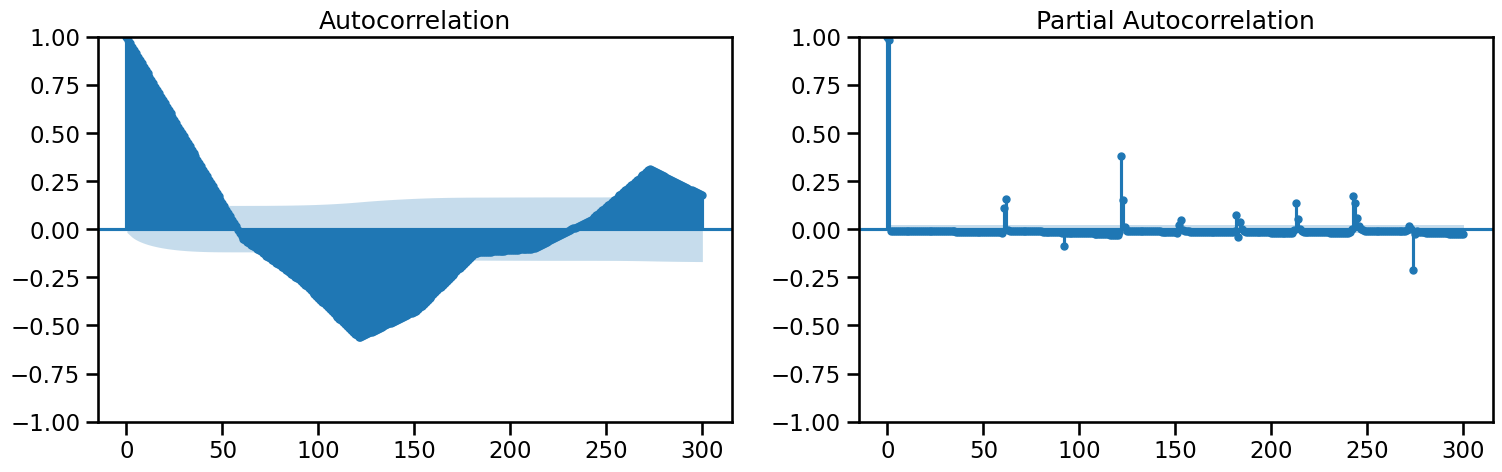

In [153]:
plot_acf_pacf(y_cmd, 300)

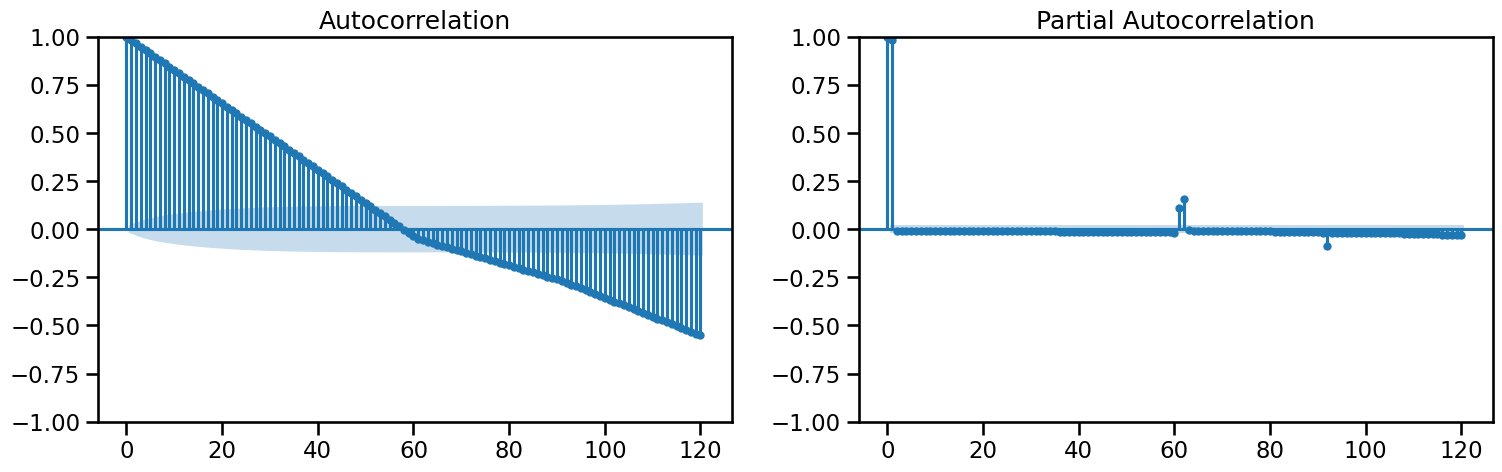

In [154]:
plot_acf_pacf(y_cmd, 120)

Вывод: использовать сдвиг более чем на лагов не имеет смысла, т.к. модель будет обманывать сама себя

# Preprocessing

## Добавление признака с экспоненциально взвешенными скользящими средними

In [249]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими
    средними (ewm) для каждого признака в DataFrame.

    Args:
        df (DataFrame): Исходный DataFrame
        span (int): Параметр span для расчета ewm (по умолчанию 10)
    Returns:
        DataFrame: DataFrame с добавленными столбцами 'ewm' для каждого признака
    """
    df_temp = df.copy()
    df_col = list(df_temp.columns)
    for col in df_col:
        col_add = f'{col}_ewm' #название для нового признака
        df_temp[col_add] = df_temp[col].ewm(span=span, adjust=False).mean()
    df_temp.drop(df_col, axis = 1, inplace = True)
    df_temp

    return df_temp

## Добавление суммы изменений признака за последние несколько временных шагов.

In [250]:
def add_weight_sum(df, size = 5, win_type = 'triang'):
  """Функция для добавления признака скользящей суммы, c весами значений

    Args:
        df (DataFrame): выборка
        df_col(str): список признаков из общей выборки для обработки
        size(int): размер окна
        metod(str): веса. Действительная оконная функция scipy.signal

    Returns:
        df_log(DataFrame): датасет с добавленным признаком скользящей суммы, c весами значений
  """
  df_temp = df.copy()
  df_col = list(df_temp.columns)
  for i in df_col:
    col_add = f'add_{size}_{i}' #название для нового признака
    df_temp[col_add] = round(df_temp[i].rolling(window = size).sum()) #создаем признак , win_type = win_type
    df_temp.fillna(0, inplace = True) #удаляем нули
  df_temp.drop(df_col, axis = 1, inplace = True)
  df_temp

  return df_temp

## Добавление лагов

In [251]:
def add_lag(df, step = 3, lag_n = 7):
  """Функция для добавления временных лагов в выборку с шагом

    Args:
        df (DataFrame): выборка
        lag_n(int): количество временных лагов
        step(int): шаг сдвига по признакам

    Returns:
        df_temp(DataFrame): датасет с добавленными временными лагами, пропуски заполнены 0
  """

  df_temp = df.copy() #coздаем новый датасет для добавления новых признаков
  df_col = list(df_temp.columns) #исходный список признаков
  col_step = [] #список признаков с шагом
  for i in range(0, len(df_col), step): #перебираем признаки
    col_step.append(df_col[i]) #формируем список признаков с шагом
  for _, col in enumerate(col_step): #перебираем список признаков с шагом
    for n, v in enumerate(range(1,lag_n)): #перебираем лаги
      col_lag = f'{col}_lag_{v}' #название для нового признака
      df_temp[col_lag] = df_temp.loc[:, col].shift(v, fill_value = 0) #создаем новый признак
  df_temp.drop(df_col, axis = 1, inplace = True)

  return df_temp

In [270]:
data_n = gestures[OMG_CH]
# Добавление признака с экспоненциально взвешенными скользящими средними
data_add_ewm = add_ewm_feature(data_n)
# Добавление суммы изменений признака за последние несколько временных шагов.
data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
# Добавление лагов
# data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
# объединение преобразований
# df = pd.concat([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
df = pd.concat([data_n, data_add_ewm, data_weight_sum], axis=1)
std_1 = StandardScaler()
X = std_1.fit_transform(df)

# Train/test

In [253]:
X_train = X[:int(X.shape[0] * 0.8)+1]
X_test = X[int(X.shape[0] * 0.8)+1:]

y_train = y_cmd_shift[:int(X.shape[0] * 0.8)+1]
y_test = y_cmd_shift[int(X.shape[0] * 0.8)+1:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8145, 150) (8145, 1)
(2036, 150) (2036, 1)


# Modeling

In [274]:
# определим балансы классов для лучшего предсказания менее представленных в выборке классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.ravel(y_train))
class_weights = dict(zip(classes, weights))

In [275]:
from sklearn import svm
# model = svm.SVC(kernel='rbf', gamma='scale', C=1000, class_weight = class_weights, break_ties=True, decision_function_shape='ovr', max_iter = -1)
model = svm.SVC(class_weight = class_weights, break_ties=True, decision_function_shape='ovr', max_iter = -1)
y_train = y_train.ravel()
model.fit(
    X=X_train,
    y=y_train
)

SVC(break_ties=True,
    class_weight={0.0: 1.6615667074663403, 1.0: 1.8672627235213204,
                  2.0: 0.32008960150907806, 3.0: 1.720532319391635,
                  4.0: 1.7337164750957854, 5.0: 1.7227157360406091})

# Metrics

In [276]:
# сделаем предсказание на обучающей выборке
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [277]:
# определим метрики
report = classification_report(y_train, y_pred)
print("Classification Report:\n", report)

# определим метрики
# f1 = f1_score(y_train, y_pred_h, average='micro')
# print("mean f_score:\n", f1)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       817
         1.0       0.93      1.00      0.96       727
         2.0       0.97      0.91      0.94      4241
         3.0       0.89      0.93      0.91       789
         4.0       0.86      0.96      0.91       783
         5.0       0.90      0.94      0.92       788

    accuracy                           0.94      8145
   macro avg       0.92      0.95      0.93      8145
weighted avg       0.94      0.94      0.94      8145



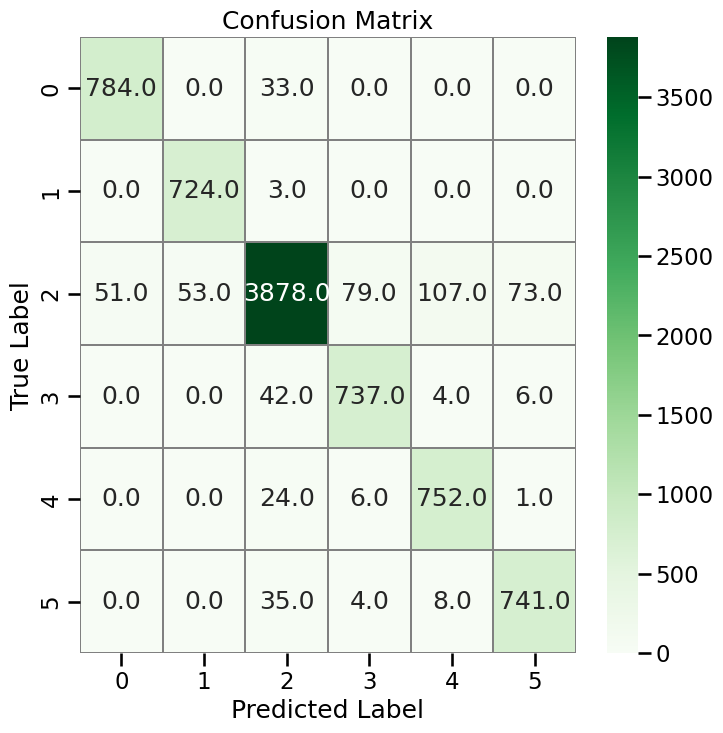

In [258]:
#confusion matrix
confusion_mtx = confusion_matrix(y_train, y_pred)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [259]:
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

### Test

              precision    recall  f1-score   support

       Close       0.82      0.96      0.88       181
  Indication       0.87      0.82      0.85       242
     Neutral       0.94      0.87      0.90      1062
        Open       0.79      0.94      0.86       182
       Pinch       0.76      0.86      0.81       187
ThumbFingers       0.72      0.72      0.72       182

    accuracy                           0.86      2036
   macro avg       0.82      0.86      0.84      2036
weighted avg       0.87      0.86      0.86      2036



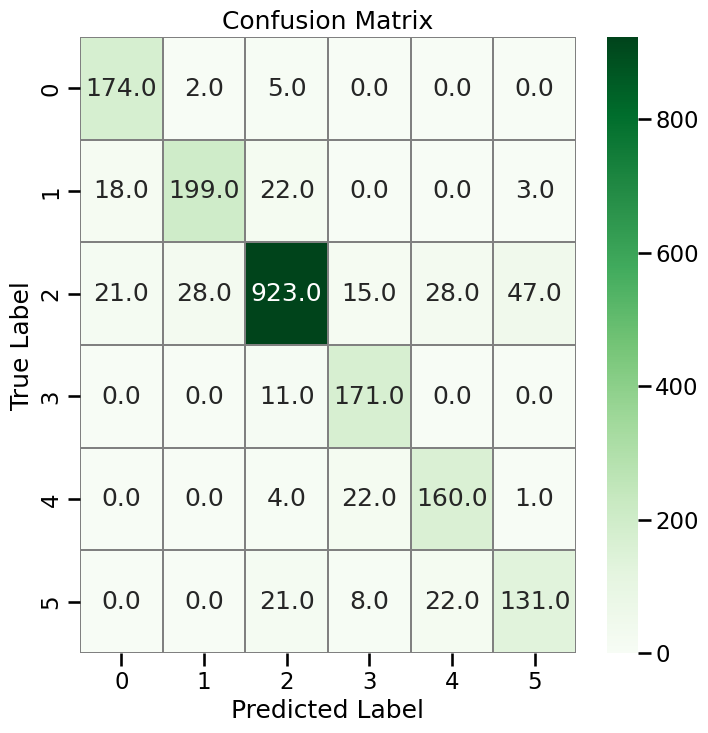

In [260]:
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

#confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_test)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Real-time inference

In [37]:
! pip install serial -q

In [261]:
import time
import serial
from IPython.display import clear_output

## Inference Utils: Put your code here

In [278]:
import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
vp = mi.VirtualPhantomClient('localhost', 1755)

In [298]:
def preprocessing(data, n_lags = 10):
  if len(data) < n_lags:
    # print(0)
    return np.zeros(150)
  else:
    data_n = pd.DataFrame(data).fillna(0.0)
    # Добавление признака с экспоненциально взвешенными скользящими средними
    data_add_ewm = add_ewm_feature(data_n)
    # Добавление суммы изменений признака за последние несколько временных шагов.
    data_weight_sum = add_weight_sum(data_n, size = 5) #, win_type = 'triang'
    # Добавление лагов
    #data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
    # объединение преобразований
    # df = np.concatenate([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
    df = np.concatenate([data_n, data_add_ewm, data_weight_sum], axis=1)
    return df[-1]

def inference(x):
    
    y = model.predict(x)
    return y[-1]

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return x

def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # 'Close'
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 1: # 'Indication'
        cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
        return cmd
    elif x == 2: # 'Neutral'
        pass
        return cmd
    elif x == 3: # 'Open'
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 4: # 'Pinch'
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    elif x == 5: # 'ThumbFingers'
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
        return cmd
    else:
        return cmd

In [287]:
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

## Inference

### Offline (dataset)

In [201]:
df_temp = gestures.iloc[:, :52]
df_columns = df_temp.columns
df = StandardScaler().fit_transform(df_temp)
df_sim = pd.DataFrame(df, columns = df_columns)
print(df_sim.shape)

(10181, 52)


In [202]:
df_sim

,ts,td,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,-1.731881,0.0,-0.000830,-0.001503,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.001709,-0.003987,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.731540,0.0,-0.000830,-0.001503,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.001709,-0.003987,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.731200,0.0,0.024882,0.048833,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.001709,-0.003987,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.730860,0.0,-0.000830,-0.001503,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.001709,-0.003987,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.730520,0.0,-0.000830,-0.001503,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.001709,-0.003987,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10176,1.730520,0.0,-1.337842,-0.555196,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.734027,-0.062988,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10177,1.730860,0.0,-1.209283,-0.530028,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.658270,-0.062988,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10178,1.731200,0.0,-1.106436,-0.479693,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.582513,-0.062988,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10179,1.731540,0.0,-1.003589,-0.504860,-0.009116,0.0,0.0,0.0,0.0,0.0,...,-0.532008,-0.062988,-0.009271,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;
ts_diff_list = []
n_lags = 10

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    # 'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])

    except Exception as e:
        print(e)

    # [Data preprocessing]
    # print(omg_sample.shape)
    sample_preprocessed  = preprocessing(y_dct['omg_sample'][-n_lags:], n_lags)
    # [/Data preprocessing]
    y_dct['sample_preprocessed'].append(sample_preprocessed)

    # [Inference]
    y_predicted        = inference(y_dct['sample_preprocessed'][-n_lags:])
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    # y_commands          = commands(y_postprocessed.argmax())
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    # y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        # print(y_commands)

    ts_diff = time.time() - ts_start
    ts_diff_list.append(ts_diff)
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1
print(round(np.array(ts_diff_list).max(),3))

0.196


In [204]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (10181, 50)
sample_preprocessed.shape = (10181, 150)
y_predicted.shape = (10181,)
y_postprocessed.shape = (10181,)


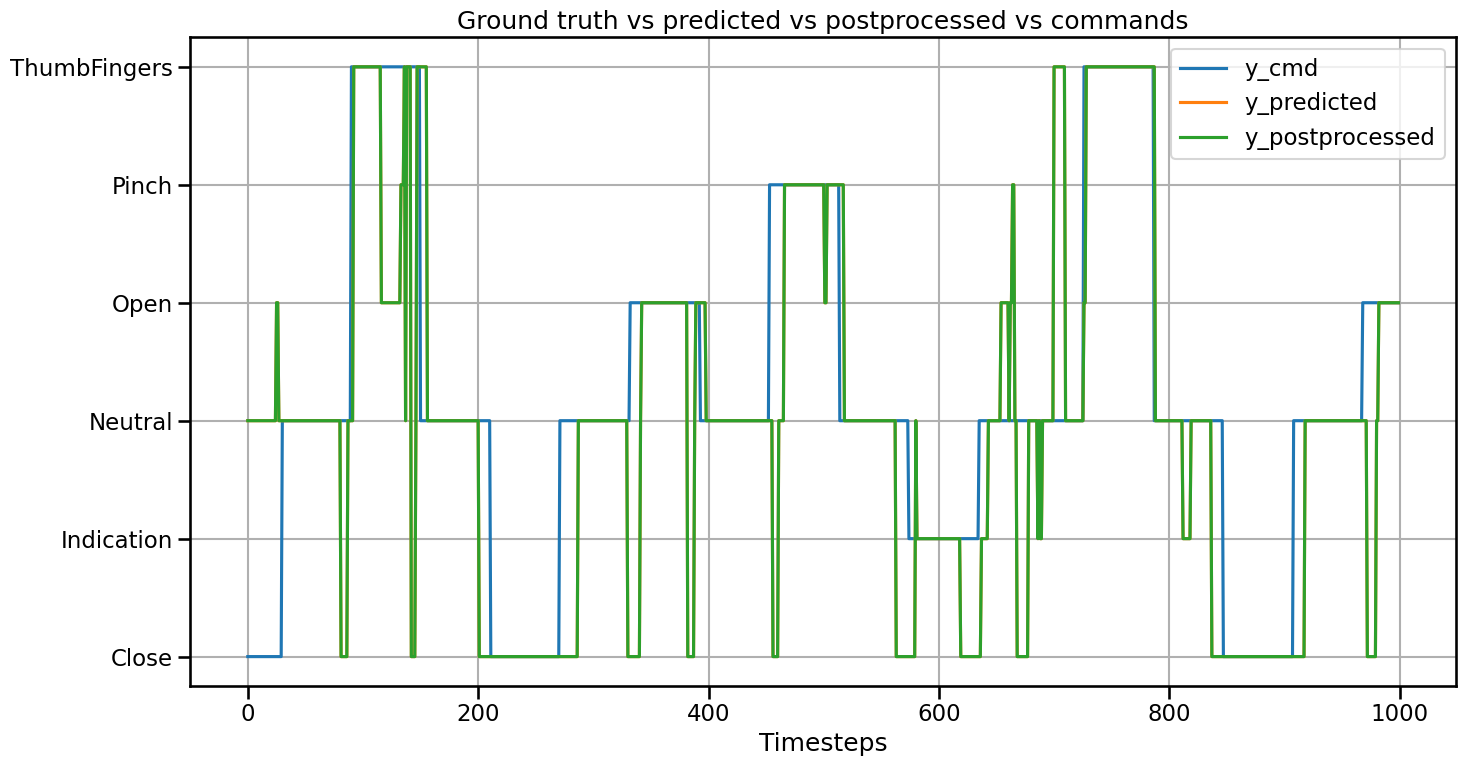

In [207]:
fig = plt.figure(figsize=(15, 8))

plt.plot(y_cmd_shift[:1000], c='C0', label='y_cmd')

# plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
# plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')

plt.plot(y_dct['y_predicted'][:1000], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'][:1000], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_cmd, y_dct['y_predicted'], target_names=GESTURES))

              precision    recall  f1-score   support

       Close       0.25      0.56      0.35       243
  Indication       0.41      0.27      0.33       242
     Neutral       0.49      0.43      0.46      1333
        Open       0.42      0.27      0.33       243
       Pinch       0.49      0.34      0.40       242
ThumbFingers       0.38      0.54      0.45       243

    accuracy                           0.42      2546
   macro avg       0.41      0.40      0.39      2546
weighted avg       0.44      0.42      0.42      2546



### Online (prosthesis or virtual hand)

In [288]:
from copy import deepcopy
import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
vp = mi.VirtualPhantomClient('localhost', 1755)

In [289]:
!ls /dev/ttyUSB*

/dev/ttyUSB0


In [290]:
TIMEOUT = 0.033
DEBUG = True

ser = None
ser_port = None
ser_port = '/dev/ttyUSB0'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, baudrate=115200, timeout=1.0)
    # time.sleep(0.2)

    # ser.write('M0\r\n'.encode())
    # time.sleep(0.1)

    # # ser.write('S2\r\n'.encode())
    # # time.sleep(0.1)

    # ser.write('PT\r\n'.encode())
    # time.sleep(0.1)
    # ser.write('Pt\r\n'.encode())
    # time.sleep(0.1)
    # ser.flush()

    # time.sleep(0.1)

In [294]:
def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

ser.readline()
while True:
    data = parseline()
    print(f"data len: {len(data)} |", list(data), end = '                                          \r')

KeyboardInterrupt: 

In [308]:
# flush buffers
ser.reset_input_buffer()
ser.read()

i = 0;
while(ser.in_waiting):
    print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
    ser.read_all()
    time.sleep(0.005)
    i+=1;
ser.readline()
ser.readline()

i = 0
ts_old = time.time()
ts_diff = 0;
n_lags = 10
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    # 'y_commands':[],
}

ts_diffs = []
x_previous = None
y_previous = None

pack = None

prev_state = 'None'
prev_idx = -1
y_commands = vp.neutral_state.copy()

while True:

    # [Data reading]
    s = ser.readline()
    ts_start = time.time()

    try:
        sample = s.decode().replace('\n', '')
        data = np.array(list(filter(len, np.array(sample.split(" "))))).astype(float)
        [[ts, cycle_ts], omg_sample] = np.array_split(data, [2])

    except Exception as e:
        print(e)
    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed  = preprocessing(y_dct['omg_sample'][-n_lags:], n_lags)
    sample_preprocessed  = std_1.transform(sample_preprocessed[:150].reshape(1,-1))[0]
    # [/Data preprocessing]
    y_dct['sample_preprocessed'].append(sample_preprocessed[:150])

    # [Inference]
    y_predicted        = inference(y_dct['sample_preprocessed'][-n_lags:])
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(int(y_postprocessed))
    # [/Commands composition]
    
    y_dct['omg_sample'].append(omg_sample)

    # [Commands sending]
    # pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    prot_idx = deepcopy(y_commands)
    if (prot_idx!=prev_idx):
        # socket_send(row.Command)
        vp.send_cmd(**y_commands)
        prev_idx = prot_idx
    # [/Commands sending]

    y_previous = y_postprocessed


    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed, GESTURES[int(y_postprocessed)])
        # print(y_commands)
        # print(pack)

    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

OSError: [Errno 5] Input/output error

In [305]:
sample_preprocessed.shape

(1, 150)

In [229]:
y_dct['sample_preprocessed'][-n_lags:][-1][:50]

array([  3.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,  13.,   0.,
         6.,   8.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,  -7.,
       -13.,  -8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])

In [198]:
[x.shape for x in y_dct['sample_preprocessed'][-n_lags:]]

[(150,),
 (150,),
 (150,),
 (150,),
 (150,),
 (150,),
 (150,),
 (150,),
 (150,),
 (156,)]

In [175]:
y_predicted

0.0

In [71]:
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

In [72]:
y_postprocessed

2.0

In [74]:
y_predicted

2.0

In [68]:
sample_preprocessed.reshape(-1,1)

array([[0.        ],
       [2.04584248],
       [6.        ],
       [1.        ],
       [3.        ]])

In [69]:
model.predict(sample_preprocessed.reshape(-1,1))

ValueError: X has 1 features, but SVC is expecting 200 features as input.

# Draft

In [ ]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];

# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))